## Velocity Dispersion Testing

In [1]:
import ctypes
import time
import scipy.special as sp
from matplotlib import pyplot as plt
import numpy as np
from colossus.cosmology import cosmology

cosmo = cosmology.setCosmology('planck18')

ibc = ctypes.CDLL("../cmake-build-debug/lib/libfoo.so")

### p_n

In [2]:
sersic_index = np.linspace(1, 6, 200)
res_store_c = np.zeros_like(sersic_index)
res_store_py = np.zeros_like(sersic_index)

In [3]:
ibc.p_nex.argtypes = [ctypes.c_float]
ibc.p_nex.restype = ctypes.c_float 

start = time.process_time()

for i, n in enumerate(sersic_index):
    res_store_c[i] = ibc.p_nex(float(n))

print("Time: {} seconds".format(time.process_time() - start))

Time: 0.0027300000000001212 seconds


In [4]:
def p_n_func(n):
    return 1 - (0.6097/n) + (0.00563/(n**2))

start = time.process_time()

for i, n in enumerate(sersic_index):
    res_store_py[i] = p_n_func(n)
    
print("Time: {} seconds".format(time.process_time() - start))


Time: 0.0007380000000001274 seconds


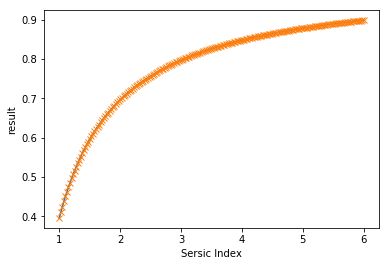

In [5]:
plt.figure()
plt.plot(sersic_index, res_store_c)
plt.plot(sersic_index, res_store_py, 'x')
plt.xlabel("Sersic Index")
plt.ylabel("result")
plt.show()

### testing de-projected density $\rho(r)$

In [6]:
R = 0.001
r_range, spacing = np.linspace(R, 1000, 1000, retstep = True)
HLR = 30.
beta = 0.1
SersicIndex = 2.
stellar_mass = 10**7
halo_rs = HLR
halo_c = 40
omega_m = cosmo.Om0
H = cosmo.H0

store = np.zeros_like(r_range)

In [7]:
ibc.density.argtypes = [ctypes.c_float, 
                        ctypes.c_float, 
                        ctypes.c_float,
                        ctypes.c_float,
                        ctypes.c_float,
                        ctypes.c_float,
                        ctypes.c_float,
                        ctypes.c_float,
                        ctypes.c_float,
                        ctypes.c_float]

ibc.density.restype = ctypes.c_float 


In [8]:
for i, value in enumerate(r_range):
    store[i] = ibc.density(value, R, beta, HLR, SersicIndex, stellar_mass, halo_rs, halo_c, omega_m, H)

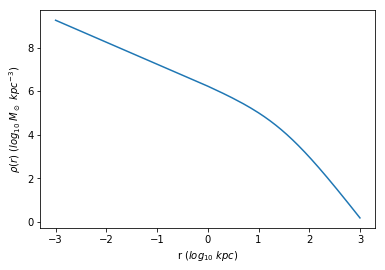

In [9]:
plt.figure()
plt.plot(np.log10(r_range), np.log10(store) )
plt.xlabel(r"r ($log_{10}$ $kpc$)")
plt.ylabel(r"$\rho (r)$ ($log_{10}$ $M_\odot$ $kpc^{-3}$)")
plt.show()

In [10]:
ibc.total_mass.argtypes = [ctypes.c_float, 
                            ctypes.c_float, 
                            ctypes.c_float,
                            ctypes.c_float,
                            ctypes.c_float,
                            ctypes.c_float,
                            ctypes.c_float,
                            ctypes.c_float]

ibc.total_mass.restype = ctypes.c_float 

/Users/christophermarsden/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


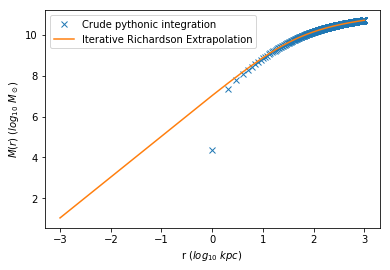

In [11]:
Integral_store = np.zeros_like(r_range)
C_integral_store = np.zeros_like(r_range)

for i, value in enumerate(r_range):
    Integral_store[i] = np.sum(store[:i] * 4 * np.pi *(r_range[:i]**2) * spacing)
    C_integral_store[i] = ibc.total_mass(value, HLR, SersicIndex, stellar_mass, halo_rs, halo_c, omega_m, H)


plt.figure()
plt.plot(np.log10(r_range),  np.log10(Integral_store), 'x', label = 'Crude pythonic integration')
plt.plot(np.log10(r_range), np.log10(C_integral_store), label = 'Iterative Richardson Extrapolation')
plt.xlabel(r"r ($log_{10}$ $kpc$)")
plt.ylabel(r"$M(r)$ ($log_{10}$ $M_\odot$)")
plt.legend()
plt.show()

### K_Kernel

In [12]:
ibc.K_Kernel.argtypes = [ctypes.c_float, ctypes.c_float]
ibc.K_Kernel.restype = ctypes.c_float 

In [13]:
def pythonic_K(u, B):
    
    def better_beta(a, b, z):
        if a < 0:
            beta = pow(z, a) * pow((1 - z), b) + (a + b) * better_beta(a + 1, b, z);
            beta = beta/a
            return beta
        else:
            beta = sp.betainc(a, b, z)
            return beta
    prefactor = 0.5 * u**(2*B-1)
    
    term1 = ((3/2) - B) * (np.pi**0.5) * ( (sp.gamma(B - 0.5)) / (sp.gamma(B)) )
    term2 = B * (better_beta(B + 0.5, 0.5, 1/(u**2)))
    term3 = better_beta(B - 0.5, 0.5, 1/u**2)
    
    res = prefactor * (term1 + term2 - term3)
    return res

In [14]:
Beta = 0.1
u_range = np.linspace(1, 100, 100)
k_store = np.zeros_like(u_range)
k_store_py = np.zeros_like(u_range)

for i, u in enumerate(u_range):
    k_store[i] = ibc.K_Kernel(u, Beta)
    k_store_py[i] = pythonic_K(u, Beta)

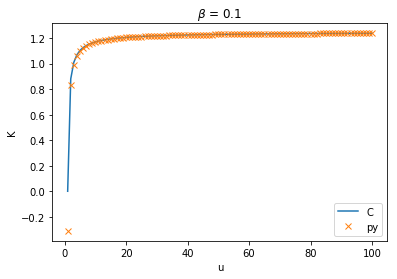

In [15]:
plt.figure()
plt.plot(u_range, k_store, label = 'C')
plt.plot(u_range, k_store_py, 'x', label = 'py')
plt.xlabel('u')
plt.ylabel('K')
plt.title(r"$\beta$ = 0.1")
plt.legend()
plt.show()

## First Integral Internals

In [16]:
ibc.first_integral_internals.argtypes = [ctypes.c_float, 
                                         ctypes.c_float,
                                         ctypes.c_float, 
                                         ctypes.c_float,
                                         ctypes.c_float, 
                                         ctypes.c_float,
                                         ctypes.c_float, 
                                         ctypes.c_float,
                                         ctypes.c_float, 
                                         ctypes.c_float]

ibc.first_integral_internals.restype = ctypes.c_float 

In [36]:
R = 10
r_range = np.linspace(R, 100, 2000)
res_store = np.zeros_like(r_range)
py_res_store = np.zeros_like(r_range)

for i, r in enumerate(r_range):
    res_store[i] = ibc.first_integral_internals(r, R, Beta, HLR, SersicIndex, stellar_mass, halo_rs, halo_c, omega_m, H)
    py_res_store[i] = pythonic_K(r/R, Beta) * \
        ibc.density(r, R, beta, HLR, SersicIndex, stellar_mass, halo_rs, halo_c, omega_m, H) *\
        ibc.total_mass(r, HLR, SersicIndex, stellar_mass, halo_rs, halo_c, omega_m, H) / r

    
res_store

array([0.00000000e+00, 6.47849902e+11, 9.03793541e+11, ...,
       8.50418534e+09, 8.49085542e+09, 8.47755622e+09])

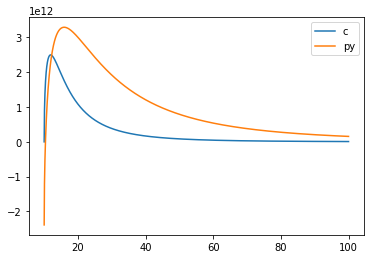

In [37]:
plt.figure()
plt.plot(r_range, res_store, label = 'c')
plt.plot(r_range, py_res_store, label = 'py' )
plt.legend()
plt.show()